In [193]:
#підключимо необхідні бібліотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [194]:
#завантажимо тренувальний датасет та переглянемо екземпляри даних
trainData = pd.read_csv("application_train.csv")
print(trainData.shape)
trainData.sample(5)

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
258077,398650,0,Cash loans,F,Y,Y,2,112500.0,526491.0,19039.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
169915,296932,0,Cash loans,M,Y,Y,1,450000.0,1347759.0,93933.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
171656,298943,0,Cash loans,F,Y,Y,0,216000.0,639396.0,28291.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
180603,309307,0,Cash loans,M,N,Y,1,112500.0,91692.0,10003.5,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
258585,399252,0,Cash loans,F,N,Y,0,81000.0,490495.5,26262.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
#завантажимо тестовий датасет та визначимо чим він відрізняється від тренувального
testData = pd.read_csv("application_test.csv")
print(testData.shape)
trainData.drop(columns = list(testData.columns))

(48744, 121)


,TARGET
0,1
1,0
2,0
3,0
4,0
...,...
307506,0
307507,0
307508,0
307509,1


In [196]:
#тестовий датасет, як і передбачалось, 
#не містить колонки TARGET, 
#значення якої необхідно визначити за допомогою натренованою моделі

In [197]:
#переглянемо кількість відсутніх даних по стовпчиках
pd.set_option('display.max_rows', None)
print((trainData.isnull().sum() / trainData.shape[0] * 100).sort_values())
pd.reset_option('all')

SK_ID_CURR                       0.000000
HOUR_APPR_PROCESS_START          0.000000
REG_REGION_NOT_WORK_REGION       0.000000
LIVE_REGION_NOT_WORK_REGION      0.000000
REG_CITY_NOT_LIVE_CITY           0.000000
REG_CITY_NOT_WORK_CITY           0.000000
LIVE_CITY_NOT_WORK_CITY          0.000000
ORGANIZATION_TYPE                0.000000
FLAG_DOCUMENT_21                 0.000000
FLAG_DOCUMENT_20                 0.000000
FLAG_DOCUMENT_19                 0.000000
FLAG_DOCUMENT_18                 0.000000
FLAG_DOCUMENT_17                 0.000000
FLAG_DOCUMENT_16                 0.000000
FLAG_DOCUMENT_15                 0.000000
FLAG_DOCUMENT_14                 0.000000
FLAG_DOCUMENT_13                 0.000000
FLAG_DOCUMENT_12                 0.000000
FLAG_DOCUMENT_11                 0.000000
FLAG_DOCUMENT_10                 0.000000
FLAG_DOCUMENT_9                  0.000000
FLAG_DOCUMENT_8                  0.000000
FLAG_DOCUMENT_7                  0.000000
FLAG_DOCUMENT_6                  0

C:\Users\thesk\AppData\Local\Temp\ipykernel_18892\2682068372.py:4: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
C:\Users\thesk\AppData\Local\Temp\ipykernel_18892\2682068372.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
C:\Users\thesk\AppData\Local\Temp\ipykernel_18892\2682068372.py:4: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


In [198]:
#як бачимо деякі колонки мають дуже багато відсутніх даних, 
#тому спробуємо позбутись тих, де відсутньо більше 25% записів. 
#також я вважаю що можна видалити перший стовпчик, оскільки це лише ID, який не є ніяким досліджуваним параметром
deleteFeatures = ["COMMONAREA_MEDI", "COMMONAREA_AVG", "COMMONAREA_MODE", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAPARTMENTS_AVG", "FONDKAPREMONT_MODE", "LIVINGAPARTMENTS_MODE", "LIVINGAPARTMENTS_MEDI", "LIVINGAPARTMENTS_AVG", "FLOORSMIN_MODE", "FLOORSMIN_MEDI", "FLOORSMIN_AVG", "YEARS_BUILD_MODE", "YEARS_BUILD_MEDI", "YEARS_BUILD_AVG", "OWN_CAR_AGE", "LANDAREA_AVG", "LANDAREA_MEDI", "LANDAREA_MODE", "BASEMENTAREA_MEDI", "BASEMENTAREA_AVG", "BASEMENTAREA_MODE", "EXT_SOURCE_1", "NONLIVINGAREA_MEDI", "NONLIVINGAREA_MODE", "NONLIVINGAREA_AVG", "ELEVATORS_MEDI", "ELEVATORS_MODE", "ELEVATORS_AVG", "WALLSMATERIAL_MODE", "APARTMENTS_MODE", "APARTMENTS_MEDI", "APARTMENTS_AVG", "ENTRANCES_MODE", "ENTRANCES_AVG", "ENTRANCES_MEDI", "LIVINGAREA_MEDI", "LIVINGAREA_MODE", "LIVINGAREA_AVG", "HOUSETYPE_MODE", "FLOORSMAX_MEDI", "FLOORSMAX_MODE", "FLOORSMAX_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BEGINEXPLUATATION_MODE", "TOTALAREA_MODE", "EMERGENCYSTATE_MODE", "OCCUPATION_TYPE"]

trainData.drop(columns = deleteFeatures, inplace = True)
testData.drop(columns = deleteFeatures, inplace = True)
print(trainData.shape)
trainData.head()

(307511, 72)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
#перевіримо, чи є дублікати даних
trainData.duplicated().sum()

0

In [200]:
#визначимо типи даних колонок
trainData.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 72, dtype: object

In [201]:
#визначимо які з них є категоріальними, а які числовими, 
#оскільки серед них є як текстові, так і числові, можна спробувати автоматизувати цей процес
numericalFeatures = trainData.select_dtypes(include=["float64", "int64"]).columns
print(numericalFeatures)


Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMEN

In [202]:
categoricalFeatures = trainData.select_dtypes(include=["object"]).columns
for feature in categoricalFeatures:
    trainData[feature] = trainData[feature].astype("category")
    testData[feature] = trainData[feature].astype("category")
print(categoricalFeatures)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')


In [203]:
#виведемо основні статичтичні дані для тренувального датасету
trainData.describe(include = "all")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


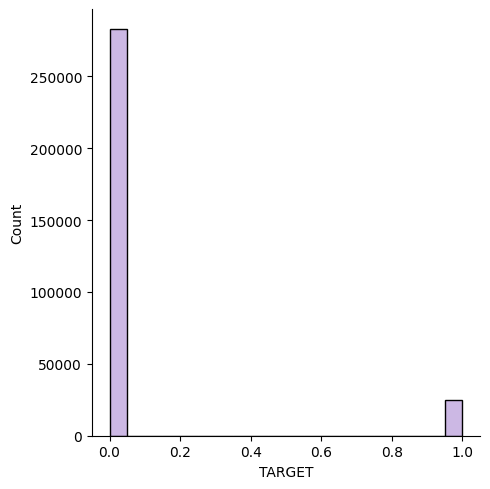

In [204]:
#визначимо наскільки тренувальний датасет збалансований
sns.displot(trainData["TARGET"])

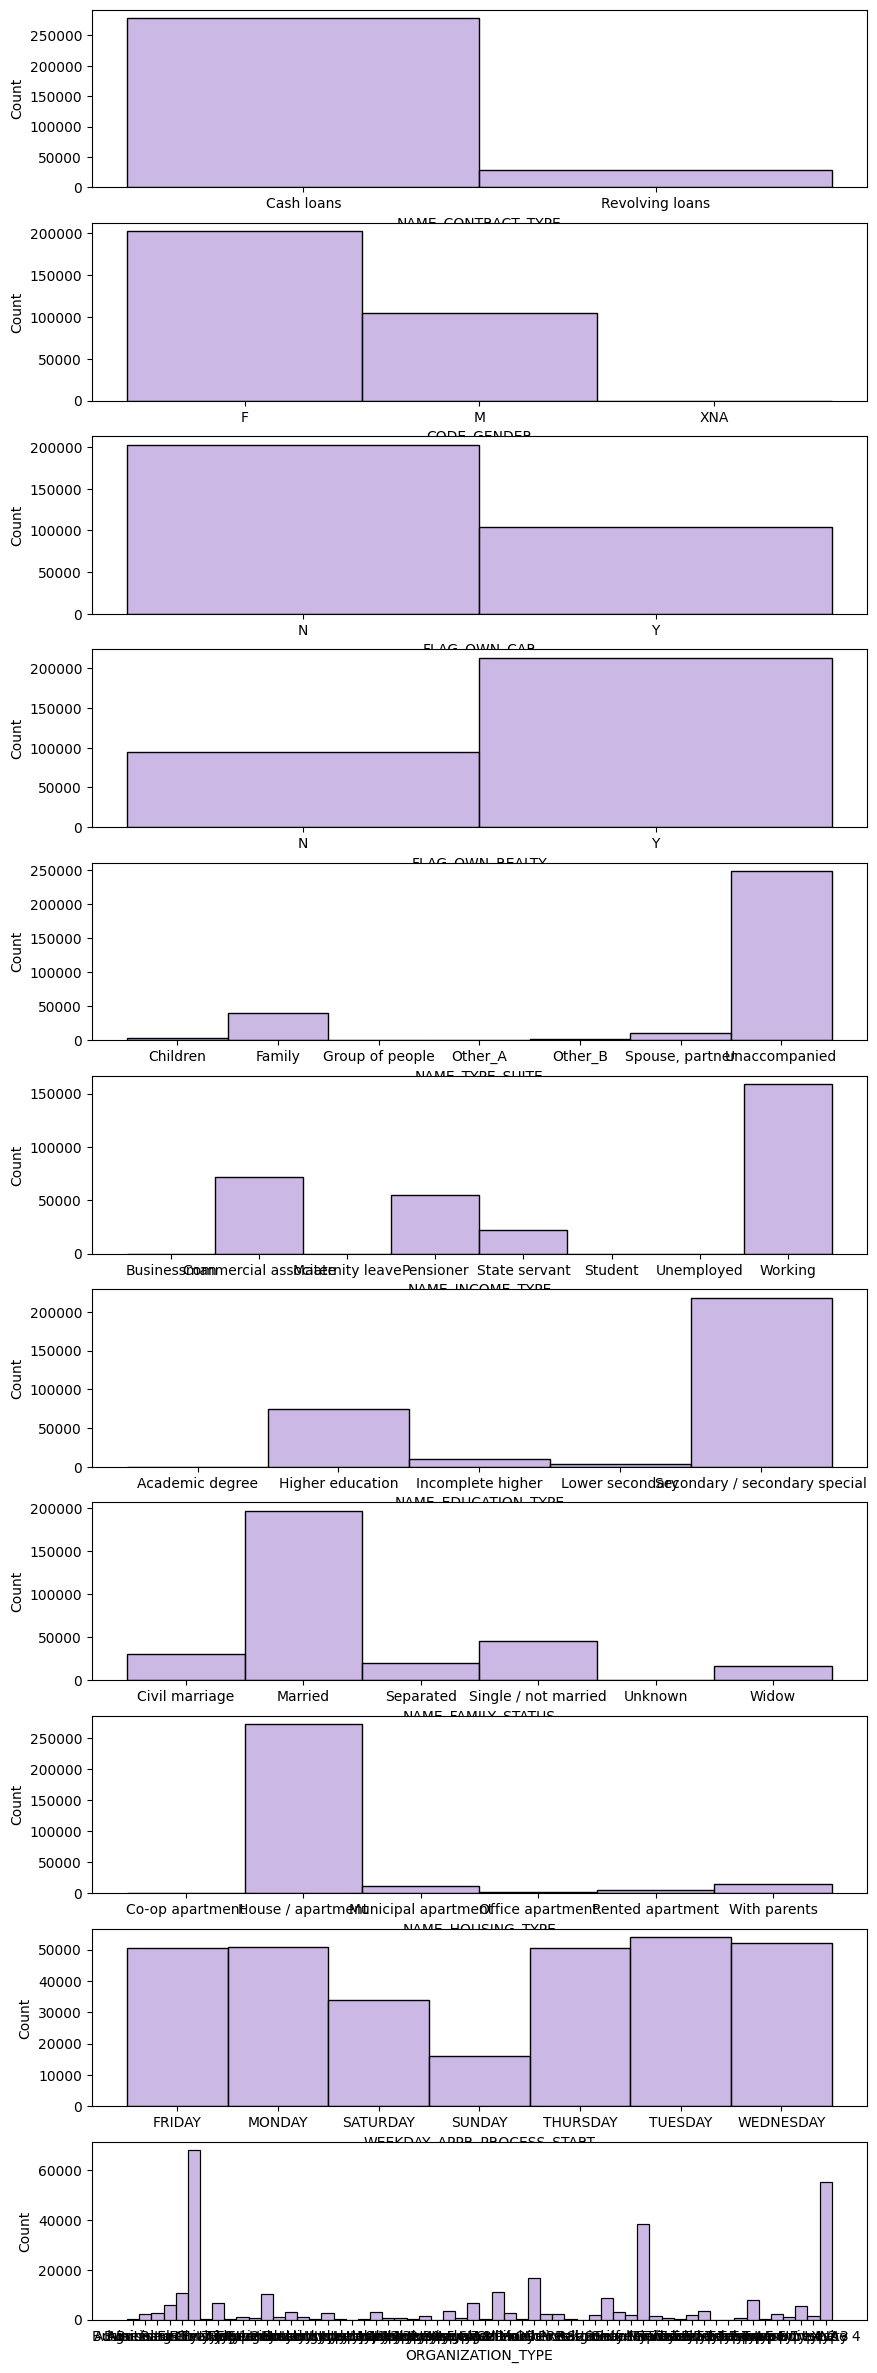

In [205]:
#з отриманого графіку можна зробити висновок, що тренувальний датасет збалансований доволі погано

#можемо переглянути розподіли інших категоріальних колонок
fig, axes = plt.subplots(nrows=len(categoricalFeatures), ncols=1)
fig.set_size_inches(10, 30)
for i, col in enumerate(categoricalFeatures):
    sns.histplot(trainData[col], kde=False, ax=axes[i])
plt.show()

array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'TARGET'}>,
        <Axes: title={'center': 'CNT_CHILDREN'}>,
        <Axes: title={'center': 'AMT_INCOME_TOTAL'}>,
        <Axes: title={'center': 'AMT_CREDIT'}>,
        <Axes: title={'center': 'AMT_ANNUITY'}>,
        <Axes: title={'center': 'AMT_GOODS_PRICE'}>,
        <Axes: title={'center': 'REGION_POPULATION_RELATIVE'}>],
       [<Axes: title={'center': 'DAYS_BIRTH'}>,
        <Axes: title={'center': 'DAYS_EMPLOYED'}>,
        <Axes: title={'center': 'DAYS_REGISTRATION'}>,
        <Axes: title={'center': 'DAYS_ID_PUBLISH'}>,
        <Axes: title={'center': 'FLAG_MOBIL'}>,
        <Axes: title={'center': 'FLAG_EMP_PHONE'}>,
        <Axes: title={'center': 'FLAG_WORK_PHONE'}>,
        <Axes: title={'center': 'FLAG_CONT_MOBILE'}>],
       [<Axes: title={'center': 'FLAG_PHONE'}>,
        <Axes: title={'center': 'FLAG_EMAIL'}>,
        <Axes: title={'center': 'CNT_FAM_MEMBERS'}>,
        <Axes: title={'ce

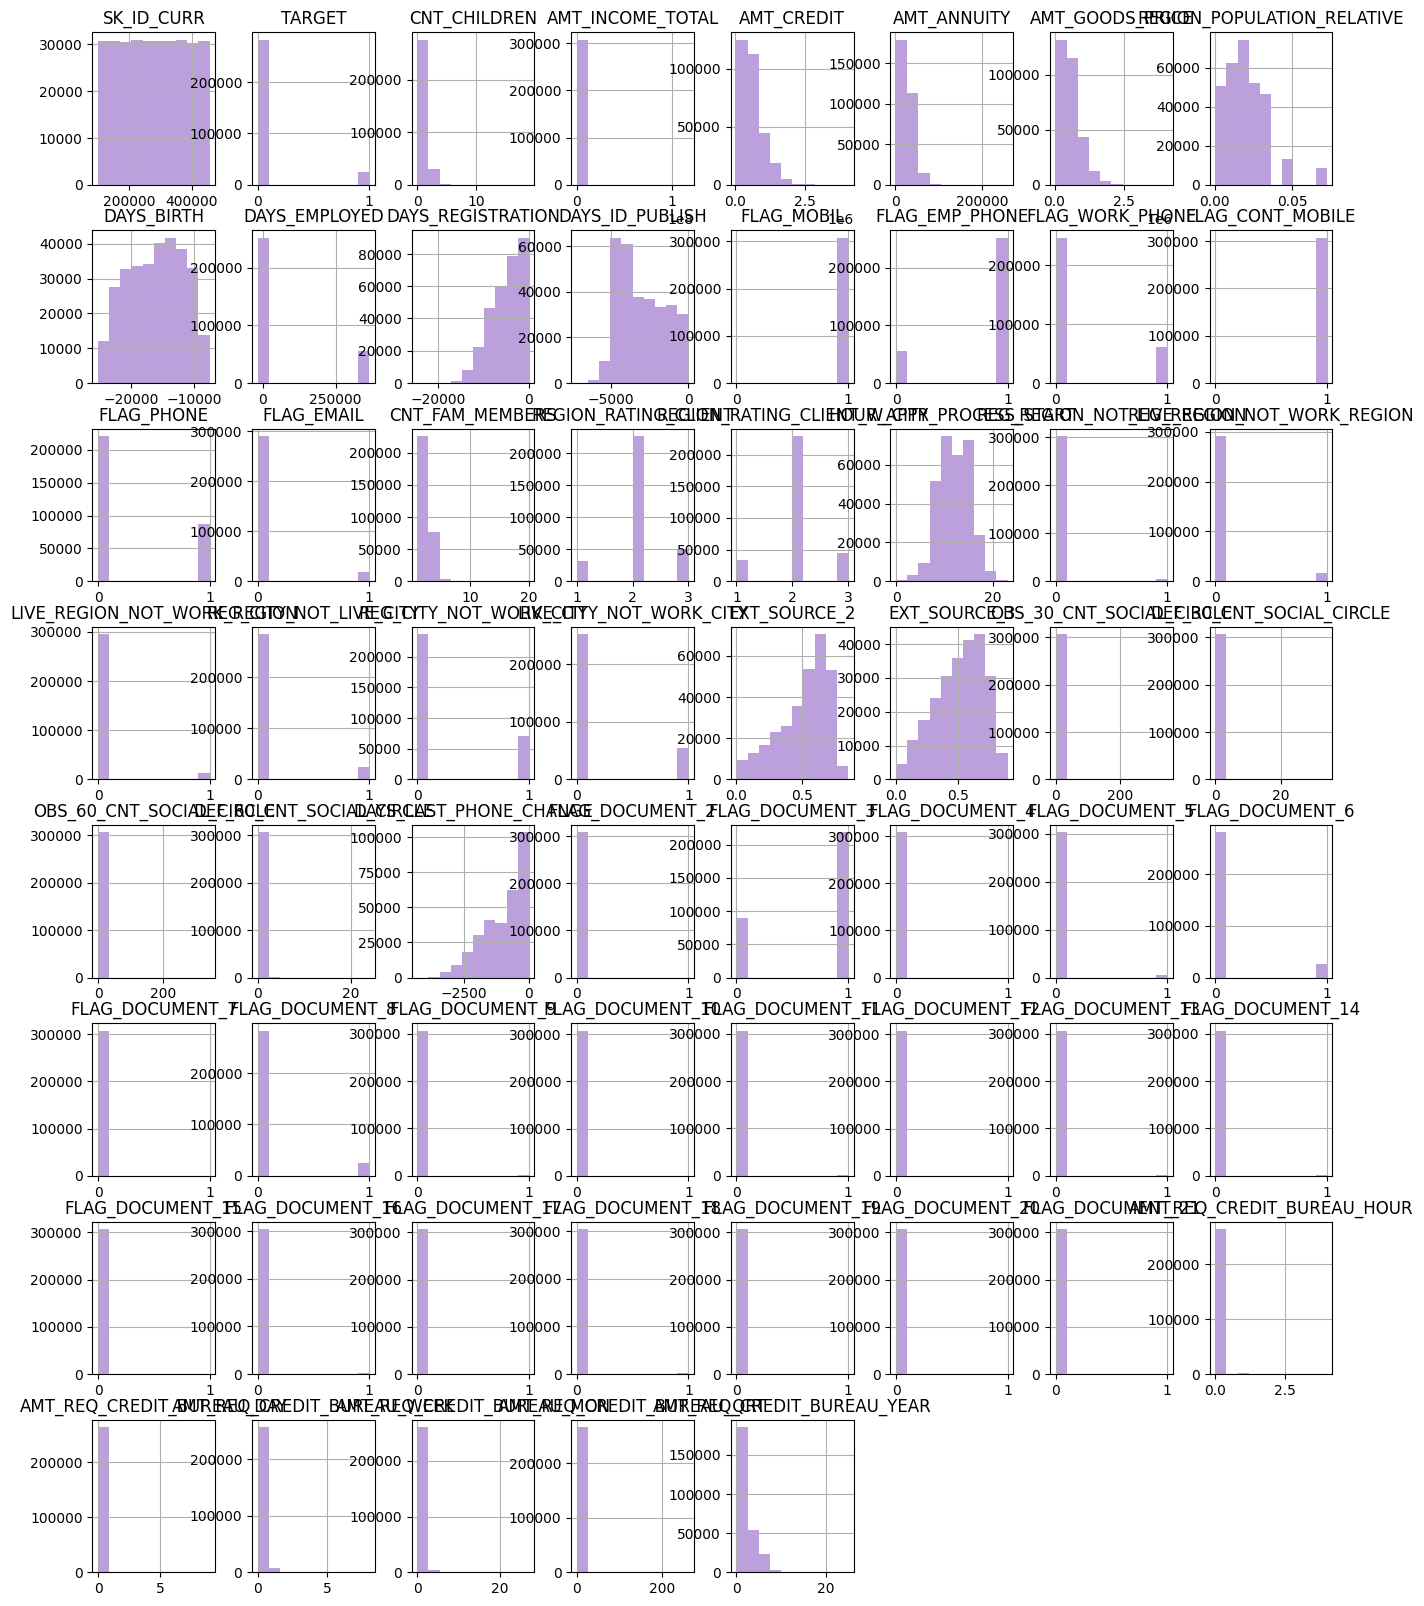

In [206]:
#переглянемо розподіл чисельних колонок
trainData[numericalFeatures].hist(figsize = (16,20))

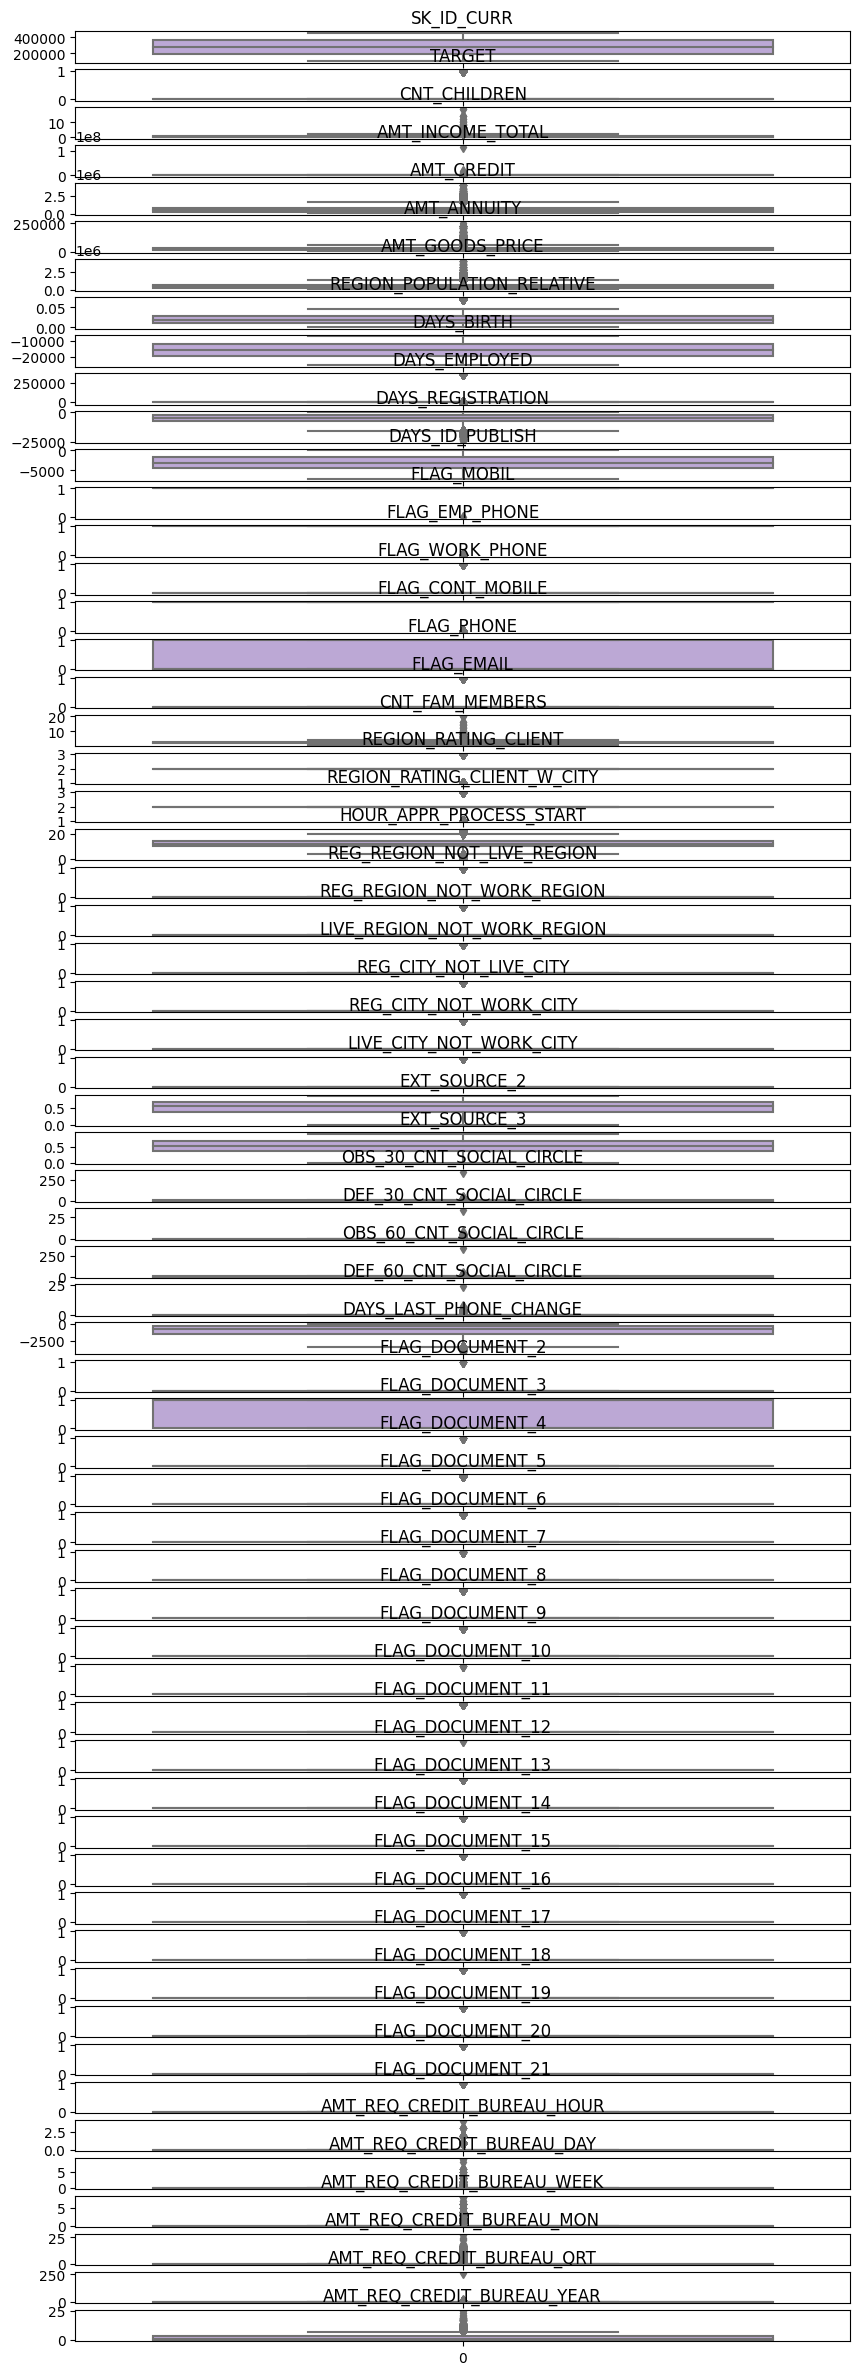

In [207]:
#визначимо чи є аутлаєри по фічам за допомогою box plot
fig, axes = plt.subplots(nrows=len(numericalFeatures), ncols=1)
fig.set_size_inches(10, 30)
for i, col in enumerate(numericalFeatures):
    ax = sns.boxplot(trainData[col], ax=axes[i])
    ax.set_title(col)
plt.show()

In [208]:
#спробуємо визначити залежніть TARGET від інших змінних за допомогою pairplot
# sns.pairplot(trainData, hue = "TARGET", size = 5)

# невдало, не компілюється (дуже багато потребує часу)

C:\Users\thesk\AppData\Local\Temp\ipykernel_18892\1683733389.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatt = trainData.corr()


<Axes: >

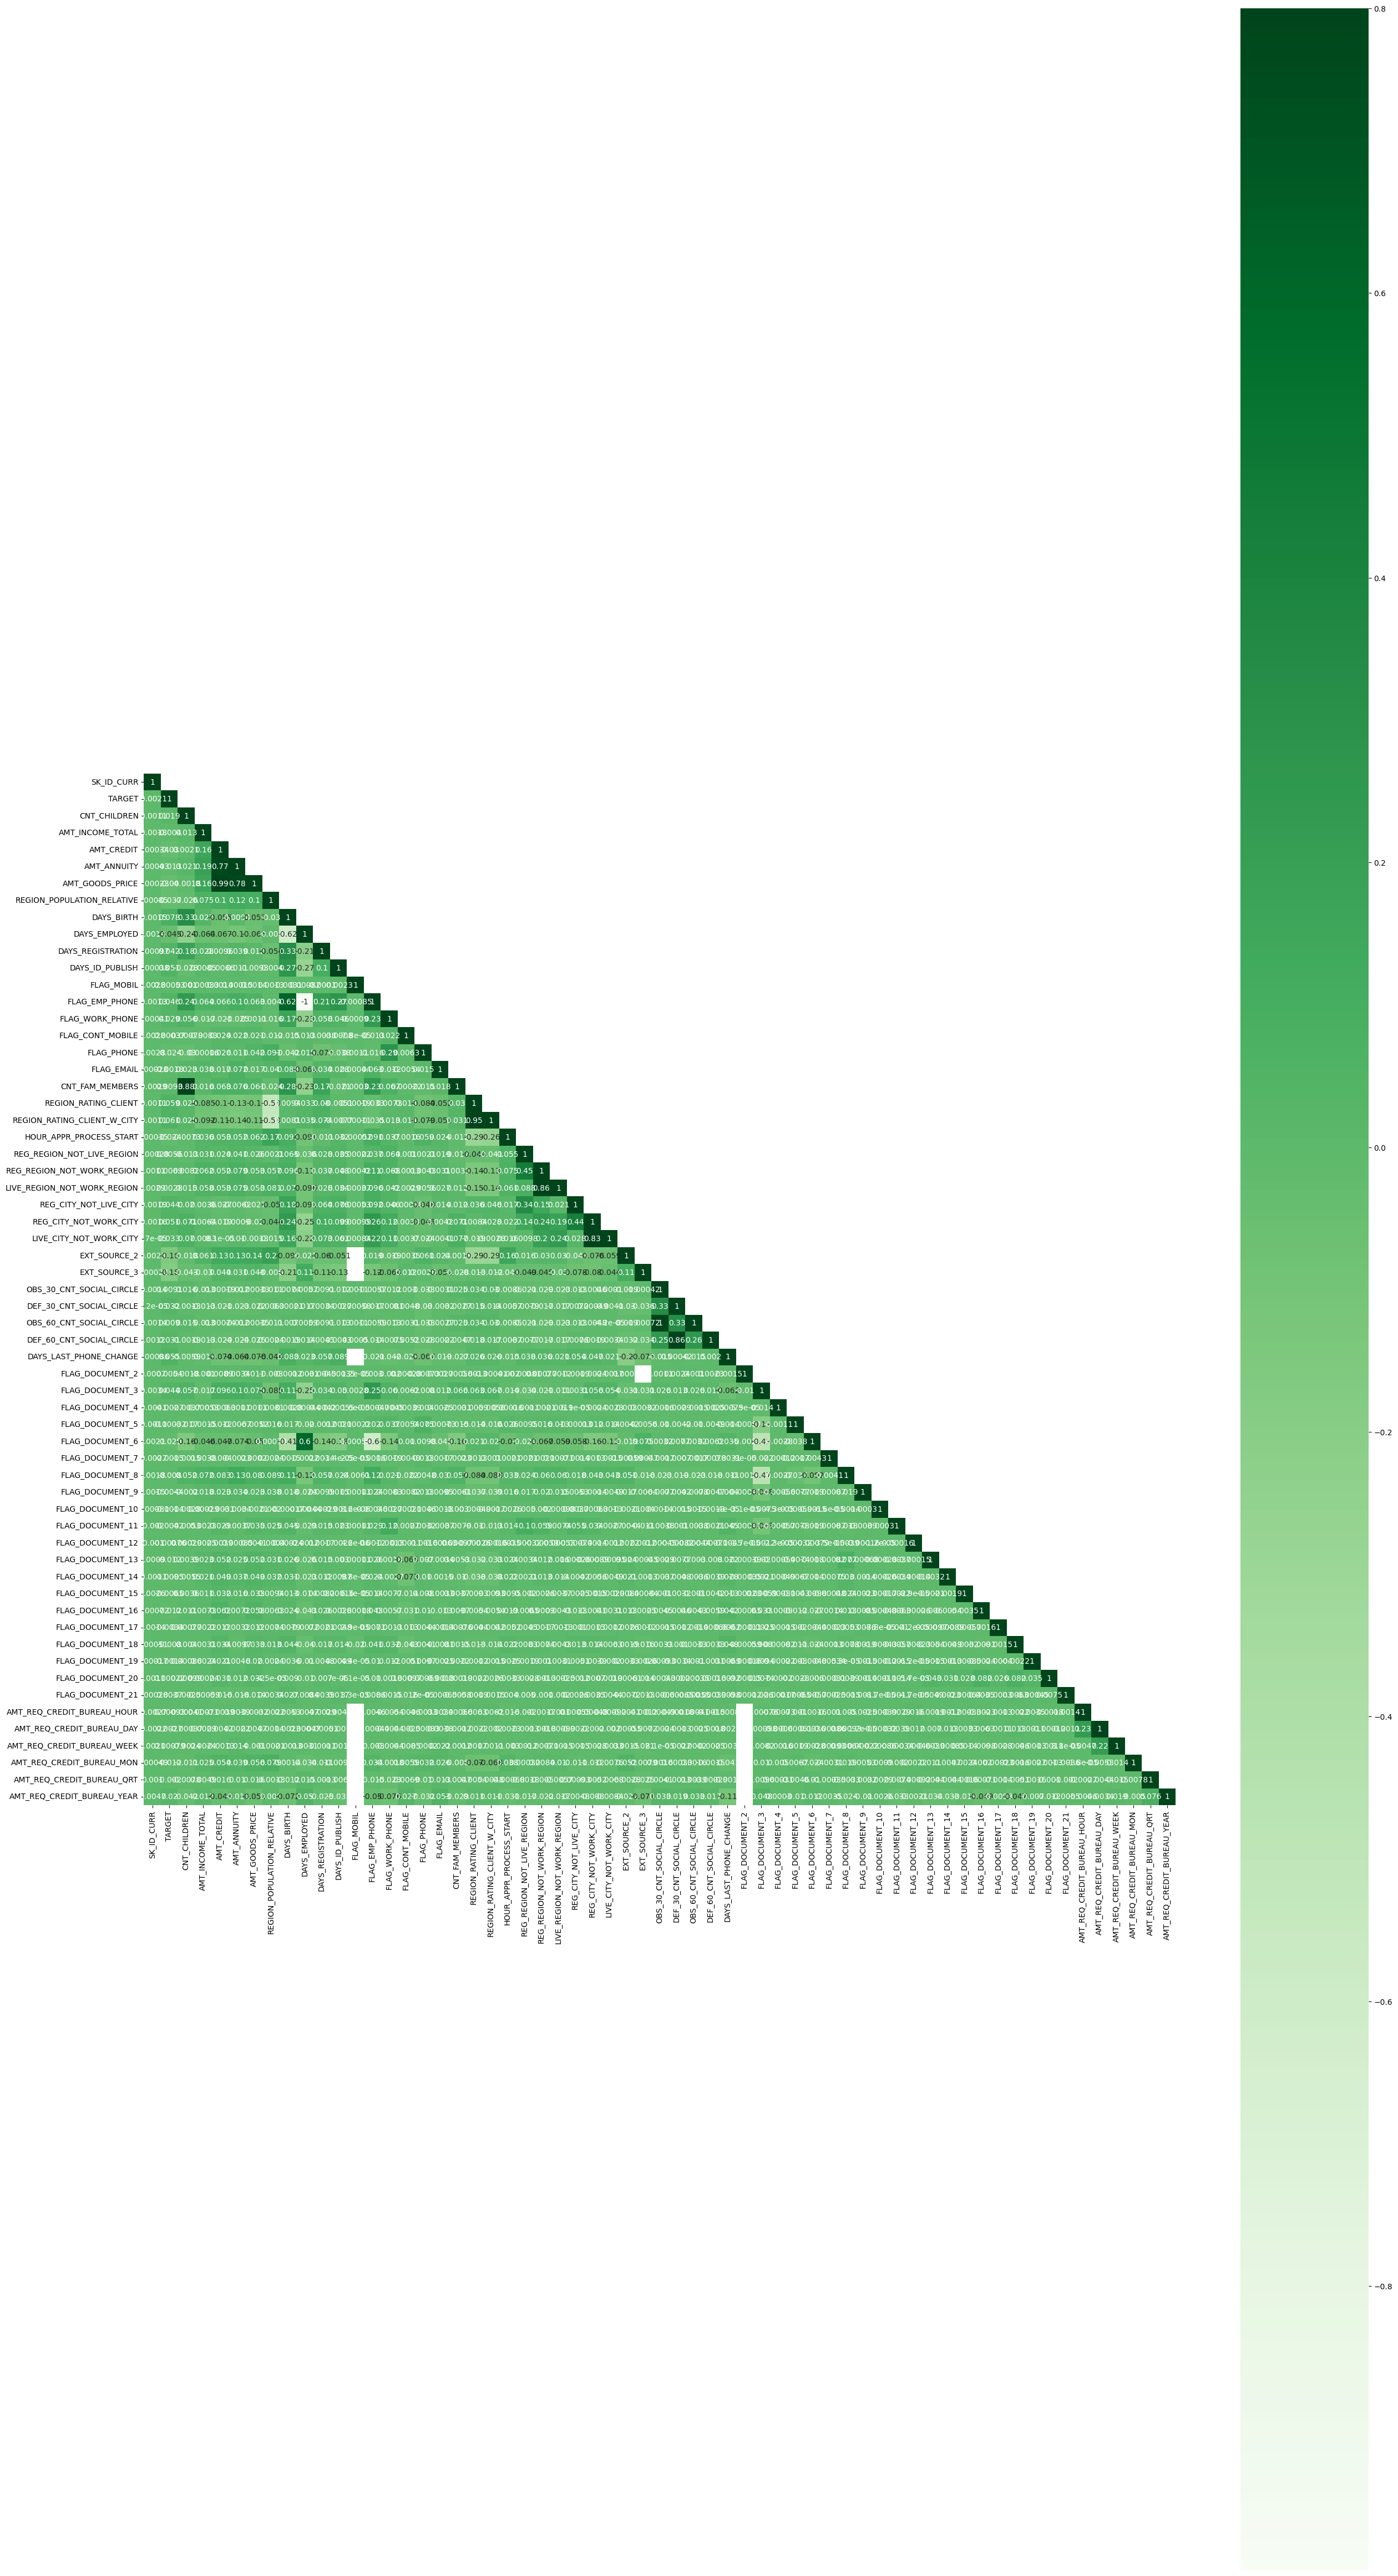

In [209]:
#переглянемо як які фічі корелюються за допомогою матриці кореляції
corrMatt = trainData.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(30, 60)
sns.heatmap(corrMatt, cmap="Greens", mask=mask, vmax=0.8, square=True, annot=True)

In [212]:
#з отриманого графіку можна побачити, що деяка кількість фіч є корельованою, тому їх можна не використовувати

trainData = trainData[["TARGET", "CODE_GENDER", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "FLAG_EMAIL", "NAME_FAMILY_STATUS",
                   "AMT_INCOME_TOTAL", "NAME_HOUSING_TYPE", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "FLAG_MOBIL", "LIVE_CITY_NOT_WORK_CITY"
                   ]]
testData = testData[["CODE_GENDER", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "FLAG_EMAIL", "NAME_FAMILY_STATUS",
                   "AMT_INCOME_TOTAL", "NAME_HOUSING_TYPE", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "FLAG_MOBIL", "LIVE_CITY_NOT_WORK_CITY"
                   ]]
columns = trainData.columns

In [213]:
#перетворимо категоріальні дані в числові аналоги для розуміння машиною
transformer = ColumnTransformer(
    transformers = [
        ("categorical", OneHotEncoder(), categorical),
        ("numerical", StandardScaler(), numerical.drop("TARGET"))
    ],
)
trainDataset = train.drop("TARGET", axis=1)
fitTrainDataset = pd.DataFrame(transformer.fit_transform(trainDataset))
columnsForClassifying = columns.drop("TARGET")

testDataset = trainData[columnsForClassifying]
fitTestDataset = pd.DataFrame(transformer.transform(testDataset))
fitTestDataset

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,0.142129,-0.456215,0.379837,0.001803,-0.467814
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.245215,0.426792,-0.460115,1.078697,0.001803,-0.467814
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,-0.427196,-0.453299,0.206116,0.001803,-0.467814
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,-0.142533,-0.473217,-1.375829,0.001803,-0.467814
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,-0.199466,-0.473210,0.191639,0.001803,2.137601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.245215,-0.047646,-0.453377,-0.984955,0.001803,-0.467814
307507,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,-0.408219,2.133617,0.169782,0.001803,-0.467814
307508,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.078050,-0.066623,-0.507774,-0.497002,0.001803,2.137601
307509,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.245215,0.009287,-0.485583,0.688107,0.001803,-0.467814


In [214]:
#розіб'ємо датасет на чатистини : 80 для тренування, 20 для валідації та проведемо тестування
trainX = fitTrainDataset
trainY = train['TARGET']
trainSplitX, validateX, trainSplitY, validateY = train_test_split(trainX, trainY, test_size=0.2)

classifyingModel = LogisticRegression(class_weight = "balanced", max_iter=10000)
classifyingModel.fit(trainSplitX, trainSplitY)
predictionTrain = classifyingModel.predict(trainSplitX)
validate = classifyingModel.predict(validateX)

print("Train data")
print("Accuracy: ", accuracy_score(trainSplitY, predictionTrain))
print("ROC_AUC: ", roc_auc_score(trainSplitY, predictionTrain))

print("Validation")
print("Accuracy: ", accuracy_score(validateY, validate))
print("ROC_AUC: ", roc_auc_score(validateY, validate))

Train data
Accuracy:  0.5767088875158531
ROC_AUC:  0.5955798095734619
Validation
Accuracy:  0.5795977431995187
ROC_AUC:  0.5982612012334553


In [217]:
print(testData.shape)

(48744, 12)


In [239]:
submit = classifyingModel.predict(trainSplitX)
testData = pd.read_csv("application_test.csv")
idCol = testData["SK_ID_CURR"]

submit = tuple(zip(idCol, submit))
temp = np.array([['SK_ID_CURR', 'TARGET']])
submit = np.vstack([temp, submit])

np.savetxt('submit.csv', submit, delimiter=',', fmt='%s')

In [240]:
submit

array([['SK_ID_CURR', 'TARGET'],
       ['100001', '1'],
       ['100005', '0'],
       ...,
       ['456223', '1'],
       ['456224', '1'],
       ['456250', '0']], dtype='<U21')

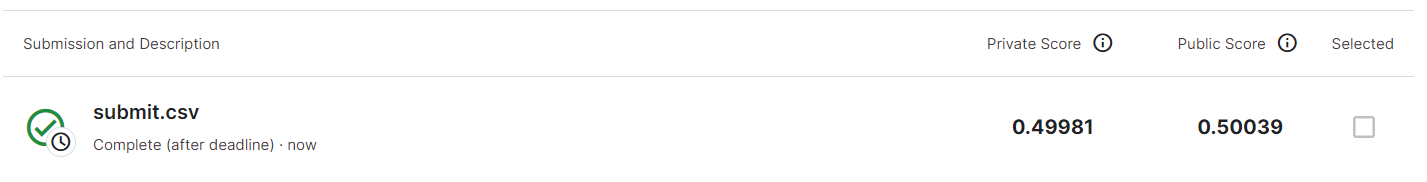

In [241]:
from IPython.display import Image
Image(filename='result.png')